# Kinematic vs dynamic
In this study, we will show how to simulate and integrate a rocking curve. 
We will see the effect of dynamical diffraction compare it to the kinematical case.

In [1255]:
from utils import*;imp.reload(dsp)
import io,os,pandas as pd,numpy as np
from subprocess import check_output
import misc_utils as mut;imp.reload(mut)
from EDutils import utilities as ut 
from blochwave import bloch                    ;imp.reload(bloch)
from blochwave import bloch_pp as bl ;imp.reload(bl)
from crystals import crystal
from scipy import integrate
%matplotlib inline

cif_file='resources/LTA.cif'
figs = (18,5)
# dsp.matplotlib.use('agg')

using dpi=96
using screenszie=[20.0,11.25] inches
using dpi=96
using screenszie=[20.0,11.25] inches
using dpi=96
using screenszie=[20.0,11.25] inches
using dpi=96
using screenszie=[20.0,11.25] inches


## Orientation Setup
We chose a random orientation $\mathbf u$ and the rotation axis to be $\mathbf e_{rot}=\mathbf u\times\mathbf e_z$.

An oscillation range and a number of points are specified to simulate a rocking curve around the $\mathbf e_{rot}$ axis about $\mathbf u$.

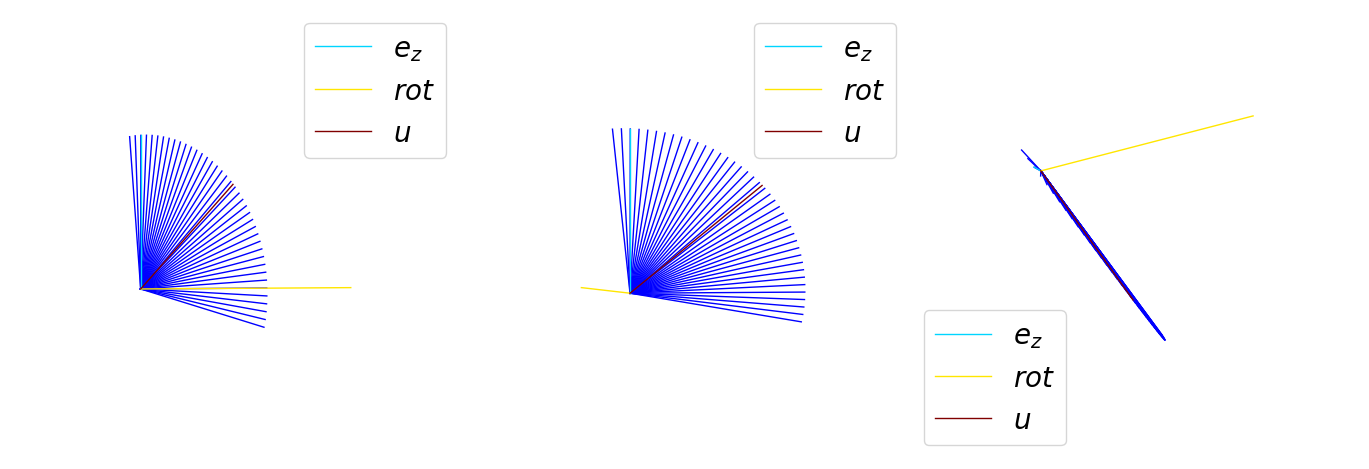

In [1186]:
# u = np.random.rand(1,3)[0]
# u = [0,1,0]
u  = np.array([0.66865363, 0.29164837, 0.6521759 ])
u  = u/np.linalg.norm(u)
uvw=mut.get_uvw(u,osc=80,npts=40)

fig = plt.figure(figsize=(15,8))

ax1=plt.subplot(1,3,1,projection='3d')
ax2=plt.subplot(1,3,2,projection='3d')
ax3=plt.subplot(1,3,3,projection='3d')

eij={'e_z':[0,0,1],'rot':np.cross(ez,u),'u':u}
cs = dsp.getCs('jet',len(list(eij.keys())) )
plts = [[[0,u[0]],[0,u[1]],[0,u[2]],'b','',1] for u in uvw ]
plts+= [[[0,ei[0]],[0,ei[1]],[0,ei[2]] , c ,'$%s$' %k,3] for c,(k,ei) in zip(cs,eij.items())]
kwargs=dict(legOpt=1,ticksOn=0)
dsp.stddisp(plts,ax=ax1,axPos=[0  ,0,0.3,1],**kwargs)
dsp.stddisp(plts,ax=ax2,axPos=[0.3,0,0.3,1],**kwargs)
dsp.stddisp(plts,ax=ax3,axPos=[0.6,0,0.3,1],**kwargs)
ax1.view_init(elev=0 , azim=0);
ax2.view_init(elev=0 , azim=-90);
ax3.view_init(elev=90, azim=0);

### Excitation errors 

The excitation error is a geometric quantity that can be calculated before any kinematic or dynamic computation.
At orientation $\mathbf u$ and 200keV, there are many beams within excitation distance of $0.005A^{-1}$. 

In [1182]:
Sargs=dict(cif_file=cif_file,Smax=0.005,keV=200,Nmax=8)
b=bloch.Bloch(path='dat/LTA',solve=False,u=u,**Sargs)
b._set_excitation_errors(Smax=Sargs['Smax'])
b._set_Vg()

print('number of beams at u:',b.df_G.shape[0])
formats = {'Sw':'{:>7.2e}','Vga':'{:>6.2f}'}
print(b.df_G.sort_values('Swa')[['Sw','Vga']][:5].to_string(
        formatters={k: v.format for k, v in formats.items()}))

imported file : resources/LTA.cif
...Nmax... 
...Excitation errors... 
...Vg... 
object saved
dat/LTA/LTA212_200keV_bloch.pkl
number of beams at u: 41
                  Sw    Vga
(0, 0, 0)  -2.85e-15   0.00
(-8, 0, 8) -1.38e-05   3.72
(4, 4, -6)  1.49e-04   1.50
(2, -7, 1) -3.11e-04   4.05
(5, 6, -8) -3.99e-04   4.91


The rocking curve can be initialized without solving for dynamical diffraction. The excitation errors can then be computed in advance.

In [1066]:
uvw=ut.get_uvw(u,osc=1,npts=100)
# Sargs['hkl']=b.df_G[['h','k','l']].values.astype(int)
# Sargs['Smax']=0
Sargs['solve']=False
name = 'test'
rock = bl.Bloch_cont(path='dat/LTA/rocks/%s' %name,uvw=uvw,tag='',Sargs=Sargs,
                     frames=np.arange(len(uvw)) )

creating directory: dat/LTA/rocks/test

imported file : resources/LTA.cif
...Nmax... 
...Structure factors...
structure factors updated.
...Excitation errors... 
...Vg... 
object saved
dat/LTA/rocks/test/u-frame__00.pkl
imported file : resources/LTA.cif
...Nmax... 
...Excitation errors... 
...Vg... 
object saved
dat/LTA/rocks/test/u-frame__01.pkl
imported file : resources/LTA.cif
...Nmax... 
...Excitation errors... 
...Vg... 
object saved
dat/LTA/rocks/test/u-frame__02.pkl
imported file : resources/LTA.cif
...Nmax... 
...Excitation errors... 
...Vg... 
object saved
dat/LTA/rocks/test/u-frame__03.pkl
imported file : resources/LTA.cif
...Nmax... 
...Excitation errors... 
...Vg... 
object saved
dat/LTA/rocks/test/u-frame__04.pkl
imported file : resources/LTA.cif
...Nmax... 
...Excitation errors... 
...Vg... 
object saved
dat/LTA/rocks/test/u-frame__05.pkl
imported file : resources/LTA.cif
...Nmax... 
...Excitation errors... 
...Vg... 
object saved
dat/LTA/rocks/test/u-frame__06.pkl
import

### Linear excitation profile 
We can see that the excitation errors evolve linearly as the rotation is performed. This is due to the flatteness of the Ewald sphere.
We can also note that all reflection do not go through the Ewald sphere at the same rate. This is due to the different distances of the reflections to the rotation axis. 
We have seen that a proper integration in the case of kinematic approximation (about $t=200A$ ) should be at about $S_{max}=0.01 A^{-1}$.

(<Figure size 1344x480 with 1 Axes>, <Axes: >)

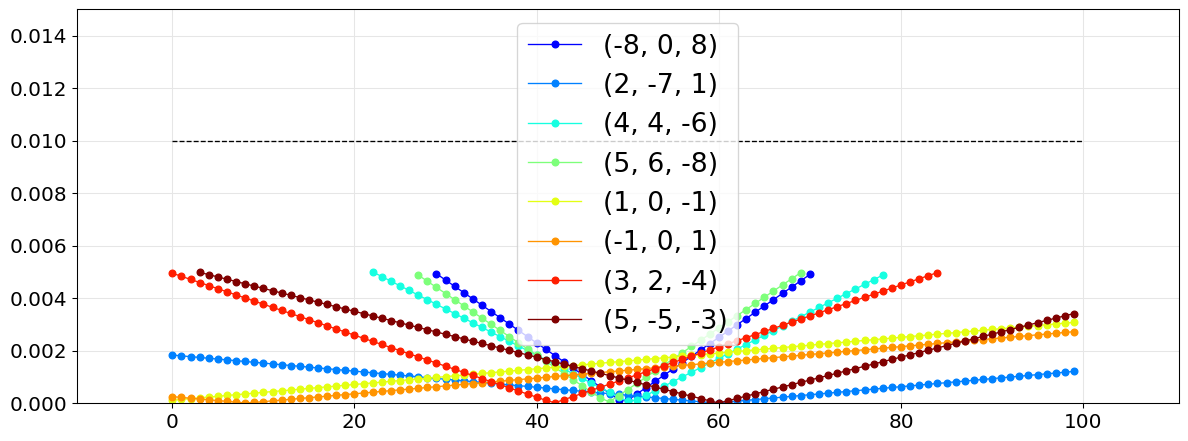

In [1096]:
hkls = [str(tuple(h)) for h in [ 
    [-8,0,8],[2,-7,1],[4,4,-6],[5,6,-8],
    [1,0,-1],[-1,0,1],[3,2,-4],[5,-5,-3]
]]
cs = dsp.getCs('jet',len(hkls))
plts = [[r.Frame,np.abs(r.Sw),[c,'-o'],h] for c,(h,r) in zip(cs,rock.beams.loc[hkls].iterrows())]
plts+= [[[0,len(rock.df)],2*[0.01],'k--','']]
dsp.stddisp(plts,xylims=['y',0,0.015],figsize=figs,legOpt=1)

### Pool of complete rocking curves

Only some of the reflections will have their rocking curve fully covered. This is because some only appear at the edges of the sweep, or last for too long as a result of being close to the rotation axis. Low resolution reflections also tend to stay longer in diffracting conditions.

In [1095]:
#### get nframes for each beam
rock.beams['nframes'] = [len(r) for r in rock.beams.Frame]
rock.beams['f_range'] = [ (np.min(r.Frame), r.Frame[np.abs(r.Sw).argmin()],np.max(r.Frame)) for h,r in rock.beams.iterrows()]
df   = rock.beams.sort_values('nframes',ascending=False)
hkls = df.index
print('number of beams : ',len(hkls))
print(rock.beams[['nframes']][:5])

### get whether its rocking curve is full
idx   = [i for i,sw in enumerate(df.Sw) if (np.max(sw)>0.004) & (np.min(sw)<-0.004)]
sw_min = [r.Frame[np.abs(r.Sw).argmin()] for h,r in df.iloc[idx].iterrows()]
hklf  = df.iloc[idx].index
print('number of full beams : ',len(hklf))
print(hklf)

number of beams :  90
             nframes
(-1, -2, 2)       45
(-1, -7, 4)       68
(-1, 0, 1)       100
(-2, -2, 3)       55
(-2, -7, 5)       62
number of full beams :  22
Index(['(3, 2, -4)', '(-5, 0, 5)', '(3, 4, -5)', '(-2, -7, 5)', '(4, 4, -6)',
       '(7, -3, -6)', '(-3, -7, 6)', '(-6, 0, 6)', '(-5, -2, 6)',
       '(-6, -2, 7)', '(4, 6, -7)', '(5, 4, -7)', '(8, -3, -7)', '(-7, 0, 7)',
       '(-4, -7, 7)', '(5, 6, -8)', '(4, 8, -8)', '(8, -1, -8)', '(-5, -7, 8)',
       '(-8, 0, 8)', '(-7, -2, 8)', '(6, 4, -8)'],
      dtype='object')


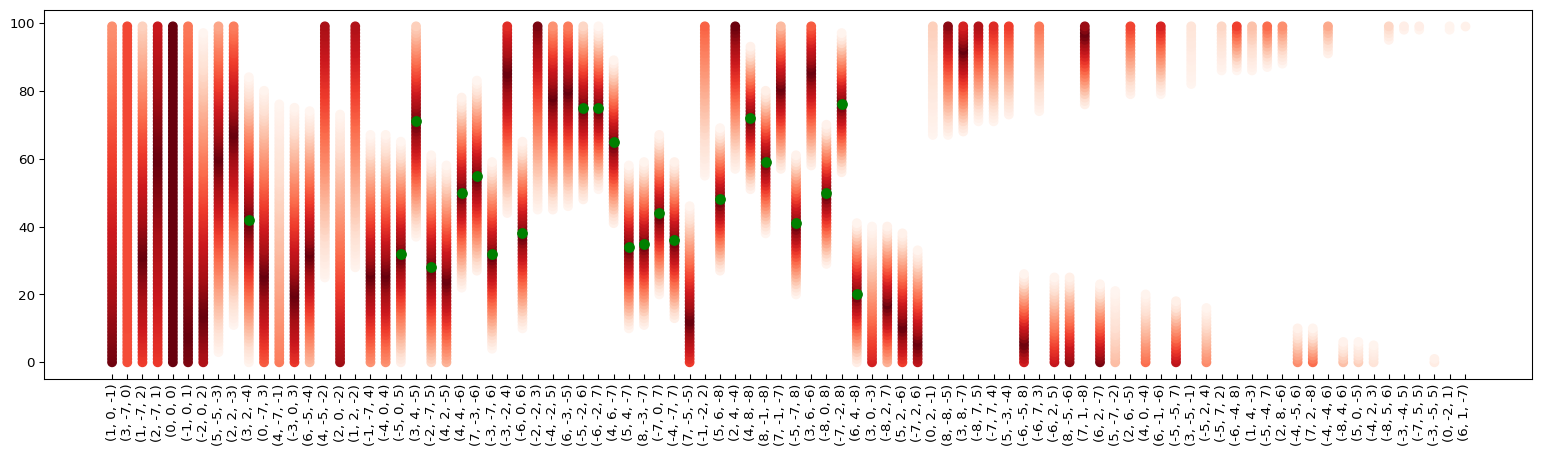

In [1091]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

###colormap
cmaps=('PuRd','OrRd_r')
cmaps=('Reds','Reds_r')
cm = mcolors.LinearSegmentedColormap.from_list('my_cmap', np.vstack((
    plt.get_cmap(cmaps[0])(np.linspace(0, 1, 128)), 
    plt.get_cmap(cmaps[1])(np.linspace(0, 1, 128)),  
)))
# swc,vm = lambda Sw:-np.sign(Sw)*np.log10(np.maximum(np.abs(Sw),1e-10)),4
swc,vm = lambda Sw:Sw, 0.005


fig,ax = dsp.create_fig(figsize=(20,5))
for i,(h,r) in enumerate(df.iterrows()):    
    ax.scatter([i]*len(r.Frame),r.Frame,40,swc(r.Sw),cmap=cm,vmin=-vm,vmax=vm)
# ax.plot([0,len(hkls)],[100]*2,'k--')
ax.scatter(idx,sw_min,50,'g')

ax.tick_params(axis='x',direction='in',labelrotation=90);
ax.set_xticks(list(range(len(hkls))));
ax.set_xticklabels(list(hkls));
# dsp.change_ticks(ax=ax)

## The kinematic approximation
The intensity of a Bragg spot in the kinematic regime can be established [[CowleyMoodie1957](#CowleyMoodie1957),[SubramanianSpence2015](#SubramanianSpence2015)] as :
\begin{equation}
  I_{kin} = \left(\sigma v_g t\right)^2 \left(\sin\left(\pi S_gt\right)/\left(\pi S_gt \right)\right)^2
\end{equation}

where : 

- $\sigma=2\pi m_0e\lambda/h^2$ the interaction parameter (in $rad/kVA$).
- $v_g$ the Fourier components (in $V$).
- $t$ is the thickness.
- $S_g$ is the excitation error.

Note that for relativistic effect to be included one must use $m=m_0\gamma$ instead of $m_0$ in the expression of $\sigma$.

### Pendulosung thickness

We can also write $I_{kin}$ terms of pendullosung thickness 
\begin{equation}
    I_{kin} = \left(\frac{\pi t}{\xi_g}\right)^2 \textrm{sinc}^2\left(S_gt\right)
\end{equation}

where :
- $\xi_g=k_0/U_g$
- $U_g=2m_0e/h^2v_g=\sigma v_g k_0 /\pi$ are the Blochwave structure factors entries.


Note that $U_g$ can also be computed from the structure factors through : 

\begin{equation}
  U_g=\frac{F_g \gamma}{\pi\mathcal V_{cell}}
\end{equation}


Note the inclusion of $\gamma$ for relativistic effect.

In [1038]:
b=bloch.Bloch(path='dat/LTA',cif_file=cif_file,solve=False,Nmax=5)
df_Fhkl = pd.read_pickle(b.get_Fhkl_pkl())

df_Fhkl['Fga']  = np.real(np.abs(df_Fhkl.F))
df_Fhkl['Ug']   = np.real(np.abs(df_Fhkl.F*cst.meff(200)/(np.pi*b.crys.volume)))
df_Fhkl['xi_g'] = b.k0/df_Fhkl.Ug

def print_df(df,n=-1,hkl=[]):
    formats = {'Fga':'{:>6.2f}','Ug':'{:>7.2e}','xi_g':'{:>5.1f}'}
    if any(hkl):
        df=df.loc[[str(tuple(h)) for h in hkl]]
    df=df.sort_values('xi_g')[['Fga','Ug','xi_g']]
    if type(n)==int:
        df=df[:n]        
    print(df.to_string(
            formatters={k: v.format for k, v in formats.items()}))

# print_df(df_Fhkl,n=2)
print_df(df_Fhkl,hkl=[[0,0,1],[1,1,1],[0,1,1],[0,0,6],[0,2,5],[-8,0,8],[2,-7,1],[4,4,-6],[5,6,-8],[3,2,-4],[5,-5,-3]])

imported file : resources/LTA.cif
...Nmax... 
...Excitation errors... 
...Vg... 
object saved
dat/LTA/LTA001_200keV_bloch.pkl
               Fga       Ug     xi_g
(0, 0, 1)    52.41 1.38e-02   2894.6
(1, 1, 1)    50.59 1.33e-02   2998.7
(0, 0, 6)    44.39 1.17e-02   3417.7
(0, 1, 1)    38.50 1.01e-02   3940.8
(5, -5, -3)   5.92 1.56e-03  25615.1
(5, 6, -8)    4.91 1.29e-03  30910.9
(2, -7, 1)    4.05 1.07e-03  37430.0
(-8, 0, 8)    3.72 9.78e-04  40758.2
(0, 2, 5)     2.99 7.85e-04  50773.9
(4, 4, -6)    1.50 3.93e-04 101351.8


### Behaviour of off-bragg reflections 

We recall : 
\begin{equation}
    I_{kin} = \left(\frac{1}{S_g\xi_g}\right)^2 \sin^2\left(\pi S_gt\right)
\end{equation}

In a given orientation, if the excitation error is constant. Note that if $S_g\neq 0$, the intensity of a beam oscillates as the thickness increases with period $1/S_g$. This a purely geometric effect due to the Ewald sphere. Indeed, as the thickness increases, the rocking curve :
- Becomes narrower pushing the off-bragg reflection more and more into the tail of the sinc function.
- The amplitude of the rocking curve increases quadratically with thickness.

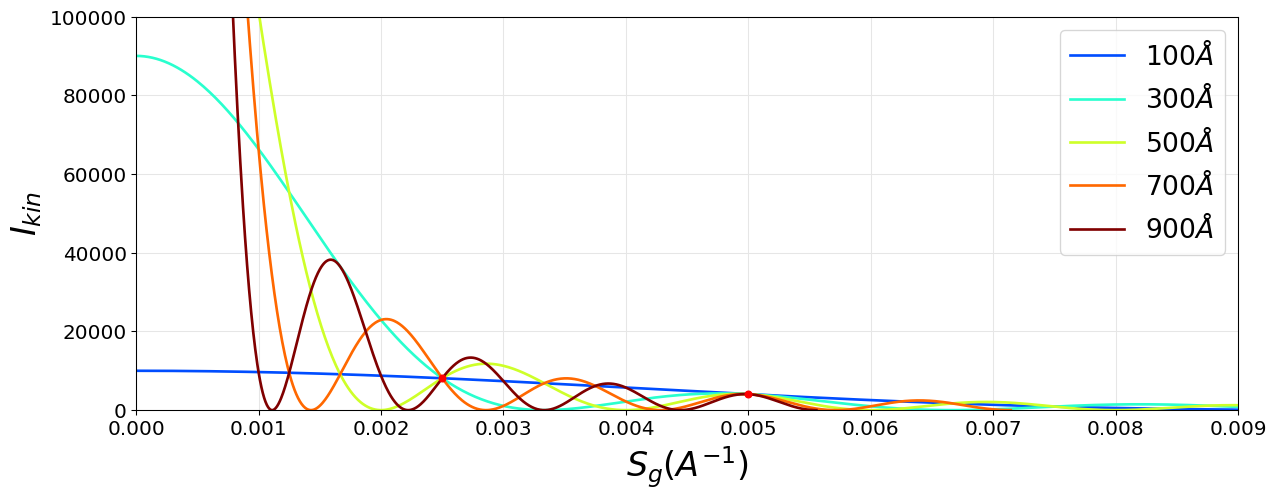

In [1039]:
x=np.linspace(0,5,1000)
y=(np.sinc(x))**2

sg0=0.005
pre=1#(np.pi/xi_g)**2
thicks = np.arange(0.5,5)/sg0
Isg0=(pre*thicks*np.sinc(sg0*thicks))**2

plts = [[x/t,t**2*y,c,'$%d\AA$' %t] for t,c in zip(thicks,dsp.getCs('jet',len(thicks)))] 
plts+= [[sg0,Isg0[0],'ro',''],[sg0/2,((thicks*np.sinc(sg0/2*thicks))[0])**2,'ro','']]
    
dsp.stddisp(plts,labs=['$S_g(A^{-1})$','$I_{kin}$'],lw=2,figsize=figs,xylims=[0,0.009,0,1e5]);

### Integrating the rocking curve

 
Since the shape of the rocking curve is identical for all reflections whose rocking curves are fully covered and the $\textrm{sinc}^2$ function integrate can be integrated [analytically](https://math.stackexchange.com/questions/13344/proof-of-int-0-infty-left-frac-sin-xx-right2-mathrm-dx-frac-pi2) $\int_{-\infty}^{\infty} \left(\frac{\sin \pi x}{\pi x} \right)^2=1$, then: 
\begin{equation}
    \int_{-\infty}^{\infty} I_{kin}(S_g) dS_g = \sigma^2 v_g^2 t = \left(\frac{\pi}{\xi_g}\right)^2 t
\end{equation}    

\begin{eqnarray}
    \int_{-\infty}^{\infty} I_{kin}(S_g) dS_g 
        &=& \int_{-\infty}^{\infty} (\pi/\xi_g)^2 t^2 \textrm {sinc}^2 \left(S_g t\right) dS_g \\
        &=& (\pi/\xi_g)^2 t \int_{-\infty}^{\infty} \textrm {sinc}^2 (x) dx \\
        &=& (\pi/\xi_g)^2 t \\
\end{eqnarray}    


$\sigma$ being constant, the integrated intensities taken at a given thickness only differ from one reflection to another through the Fourier component $v_g^2$ in the kinematic case. Note that the rocking curve integrated signal scales linearly with thickness. 

err :  [8.79389926 4.03418163 2.37023885]


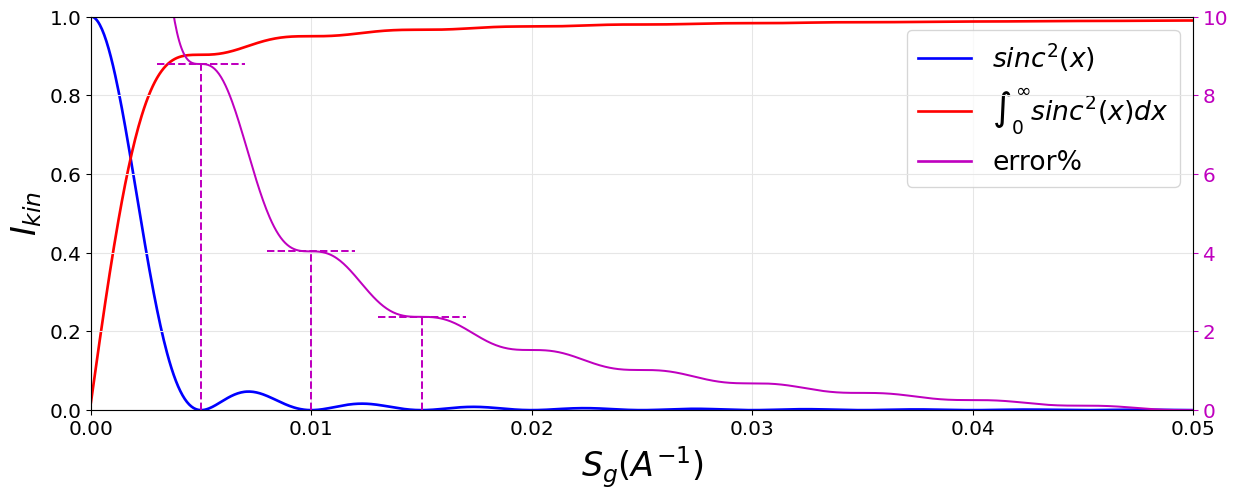

In [1063]:
x=np.linspace(0,10,1000)
t=200
sg=x/t

y=(np.sinc(x))**2
Y=integrate.cumtrapz(y,x)
#### integration errors
err = (abs(Y-Y[-1])/Y[-1])*100
v0 = err [ [np.argmin(np.abs(sg-sg0)) for sg0 in np.arange(1,4)/t]]
print('err : ' , v0)

#### display

plts=[
    [sg,y       ,'b','$sinc^2(x)$'],
    [sg[:-1],2*Y,'r','$\int_{0}^{\infty}sinc^2(x)dx$ '],    
]
legElt={'error%': 'm-',}#'I':'k-','$\int I$':'k-'}
fig,ax=dsp.stddisp(plts,labs=['$S_g(A^{-1})$','$I_{kin}$'],lw=2,figsize=figs,
            xylims=[0,0.05,0,1],legElt=legElt)


ax2 = ax.twinx()
ax2.plot(sg[:-1],err,'m')
for sg0,v in zip(np.arange(1,4)/t,v0):    
    ax2.plot(np.array([-1,1])*0.002 + sg0,[v]*2,'m--')
    ax2.plot([sg0]*2,[0,v],'m--')
dsp.standardDisplay(ax2,xylims=[0,0.05,0,10],c=['k','m'])


If performed numerically, the rocking curve integration is acccurate to 8.5%,4% and 2% after the first,second and third zero.

The zeros of the rocking curve appear at excitation errors $S_g=1/t$ and is independent of the reflection. As a guideline the excitation error should be $S_{max}=3/t$ should be good to capture the whole rocking curves so $S_{max}=0.03$ at 100A, $S_{max}=0.015$ at 200A and $S_{max}=0.01$ should be fine for larger thicknesses.

### Sampling the rocking curve 

## 2 beam theory 

For a $2\times 2$ blochwave matrix, the solution can be obtained analyticallyto yield the following theoretical 2 beam intensity for the diffracted beam : 
\begin{equation}
  I_{dyn-2} = \frac{\sin^2\left(\pi t/\xi_g\sqrt{1+w_g^2}\right)}{1+w_g^2}
\end{equation}

where $w_g=\xi_gS_g$.

Note that the primary beam is then $I_0=1-I_{dyn-2}$.

### Rocking curve


               xi_g
(1, 0, -1) 3,940.83


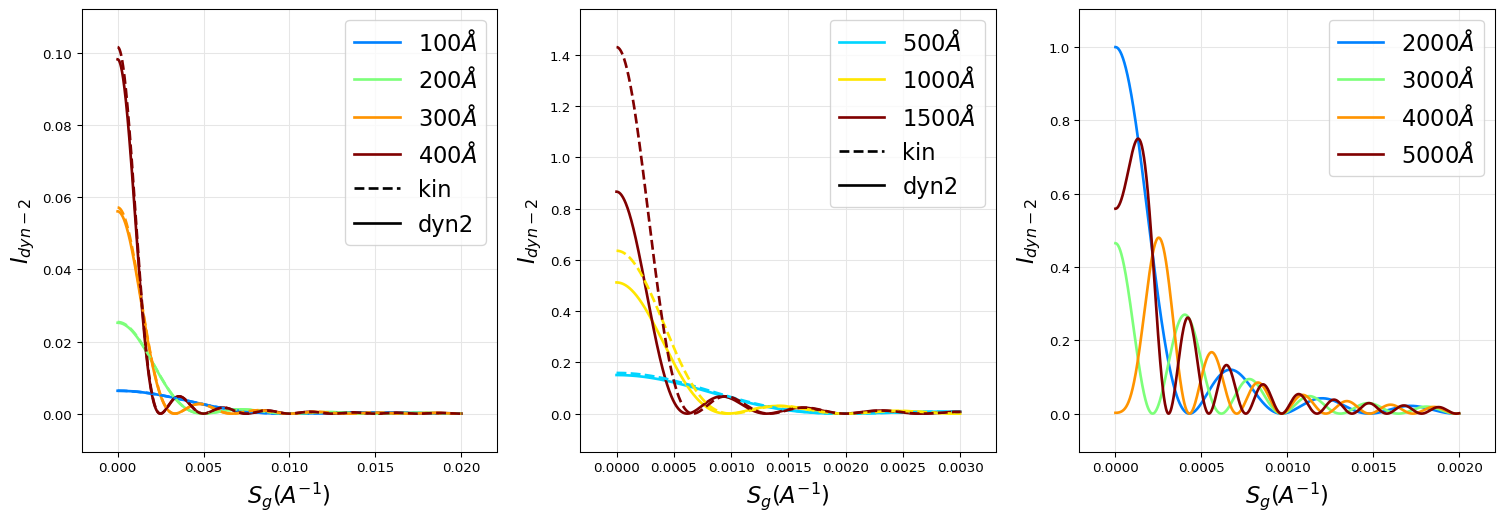

In [944]:
df = b.df_G.sort_values('xi_g')
print(df[['xi_g']][:1])
xi_g =df.xi_g[0]
Idyn = lambda wg,t,xi_g : np.abs(np.sin(np.pi * t/xi_g*np.sqrt(1+wg**2))/np.sqrt(1+wg**2))**2
Ikin = lambda sg,t,xi_g : ((np.pi*t/xi_g)*np.sinc(sg*t))**2

def plot_I2(sg,thicks,kin=True,**kwargs):
    wg=sg*xi_g
    I_dyns = [ Idyn(wg,t,xi_g) for t in thicks]
    plts = [[sg,I,c,'$%d\AA$' %t] for I,t,c in zip(I_dyns,thicks,dsp.getCs('jet',len(thicks)))] 
    legElt = {}
    
    if kin:
        I_kins = [ Ikin(sg,t,xi_g) for t in thicks]
        plts+= [[sg,I,[c,'--'],''] for I,t,c in zip(I_kins,thicks,dsp.getCs('jet',len(thicks)))] 
        legElt = {'kin':'k--','dyn2':'k-'}
    return dsp.stddisp(plts,labs=['$S_g(A^{-1})$','$I_{dyn-2}$'],lw=2,setPos=False,legElt=legElt,**kwargs);

fig,(ax1,ax2,ax3) = dsp.create_fig(rc=(1,3),figsize=(19,6))
args=dict(fonts={'lab':17,'tick':10,'leg':17})

plot_I2(sg = np.linspace(0,0.02 ,1000),thicks = [100,200,300,400]  ,kin=True ,ax=ax1,**args)#,xylims=['y',0,0.2]);
plot_I2(sg = np.linspace(0,0.003,1000),thicks = [500,1000,1500]    ,kin=True ,ax=ax2,**args)#,xylims=['y',0,1,]);
plot_I2(sg = np.linspace(0,0.002,1000),thicks = np.arange(2,6)*1000,kin=False,ax=ax3,**args);


Note that the shape of the rocking still looks similar to a sinc even deep into the dynamic regime $t=\xi_g/2$ but the side lobes tend to grow bigger and most importantly the peak amplitude does not grow as large.

### Integrating the rocking curve

3940.831132505026


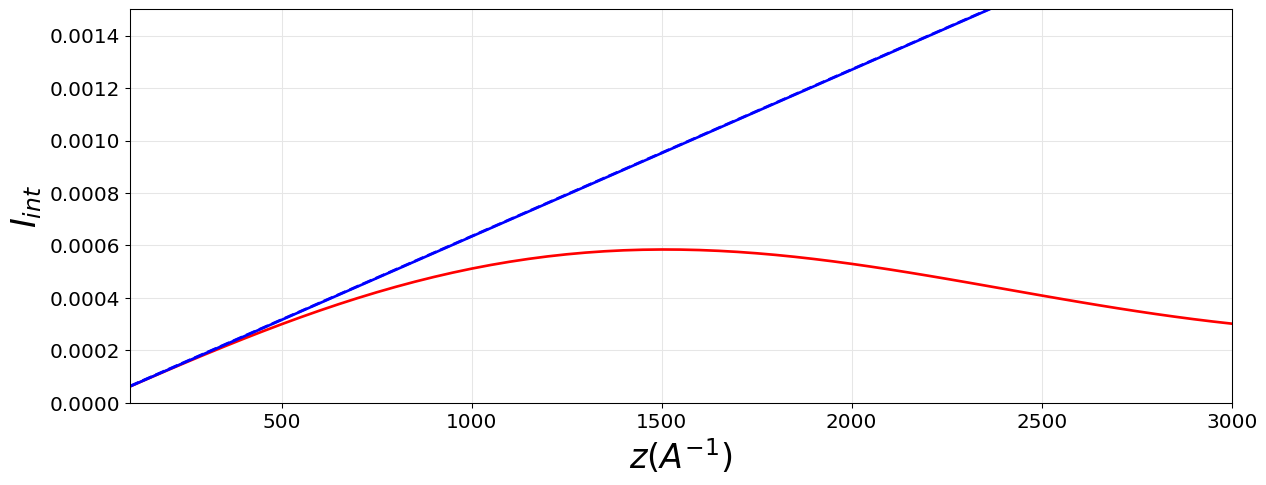

In [1061]:
thicks=np.arange(100,3001,50)
npts = 100001
xi_g = df.xi_g[0];print(xi_g)
# sg = lambda t,npts  : np.linspace(0,0.02,npts)#np.linspace(0,5/t,npts)
# dsg = lambda t,npts : 5/t/(npts-1)

sg = np.linspace(0,0.05,npts)

Idyn2 = 2*np.array([integrate.trapz(Idyn(sg*xi_g,t,xi_g),sg) for t in thicks])
Ikins = 2*np.array([integrate.trapz(Ikin(sg     ,t,xi_g),sg) for t in thicks])

# thicks=thicks[:-1]
plts =[[thicks,Idyn2,'r-','']]
plts+=[[thicks,Ikins,'b-','']]
plts+=[[thicks,(np.pi/xi_g)**2*thicks,'b--','']]
# legElt={'I':'k-','$\int I$':'k--'}
dsp.stddisp(plts,labs=['$z(A^{-1})$','$I_{int}$'],lw=2,figsize=figs,
           xylims=[100,3000,0,0.0015],#,legElt=legElt)
           );

### Simulation check 

In order to make sure the pendullosung thickness are correct we simply need to check that the oscillation period with thickness is equal to $xi_g$ in a $2\times 2$ simulation. 

As an example, we can see that reflection $(-5,0,5)$ full rocking curve ranges in frames 0 to 65 and reaches its closest point to the Ewald sphere at simulation 32 where it is $S_w = 2.6~10^{-5}A^{-1}$ from the Ewald sphere.

In [1218]:
h0 = str((-5,0,5))
r = rock.beams.loc[h0]
print('\trefl : %s' %h0)
print('frame range :',r.f_range)
print('Swmin       :',r.Sw[r.f_range[1]])
print('xi_g        :',np.real(df_Fhkl.loc[h0].xi_g))

# swmm = np.min([ np.abs(r.Sw).min() for h,r in df.iloc[idx].iterrows()])
# swmm

	refl : (-5, 0, 5)
frame range : (0, 32, 65)
Swmin       : 2.6210584620366394e-05
xi_g        : 5642.277553344294


In [1230]:
b0 = rock.load(32)
b0.df_G.sort_values('Swl')
formats = {'Sw':'{:>7.2e}','Vga':'{:>6.2f}'}
print(b0.df_G.sort_values('Swa')[['Sw','Vga']][:10].to_string(
        formatters={k: v.format for k, v in formats.items()}))

                   Sw    Vga
(0, 0, 0)    0.00e+00   0.00
(-5, 0, 5)   2.62e-05  26.89
(6, -5, -4) -3.85e-05   1.42
(1, -7, 2)   4.25e-05   4.05
(-3, -7, 6)  6.35e-05   3.25
(5, 4, -7)   3.95e-04  14.60
(0, -7, 3)   5.79e-04   5.45
(-2, -7, 5)  5.90e-04   1.73
(8, -3, -7)  6.05e-04   0.45
(-1, 0, 1)   7.14e-04  38.50


In [1228]:
import copy
b0_2x2=copy.copy(b0)
b0_2x2.set_name('b32_2x2',b0_2x2.path)
b0_2x2.solve(hkl=np.array([[0,0,0],[-5,0,5]]))


 ...assembling 2x2 matrix (structure factor shape : (33, 33, 33)) ...             
...diagonalization...
object saved
dat/LTA/rocks/test/b32_2x2.pkl


... beam vs thickness ...


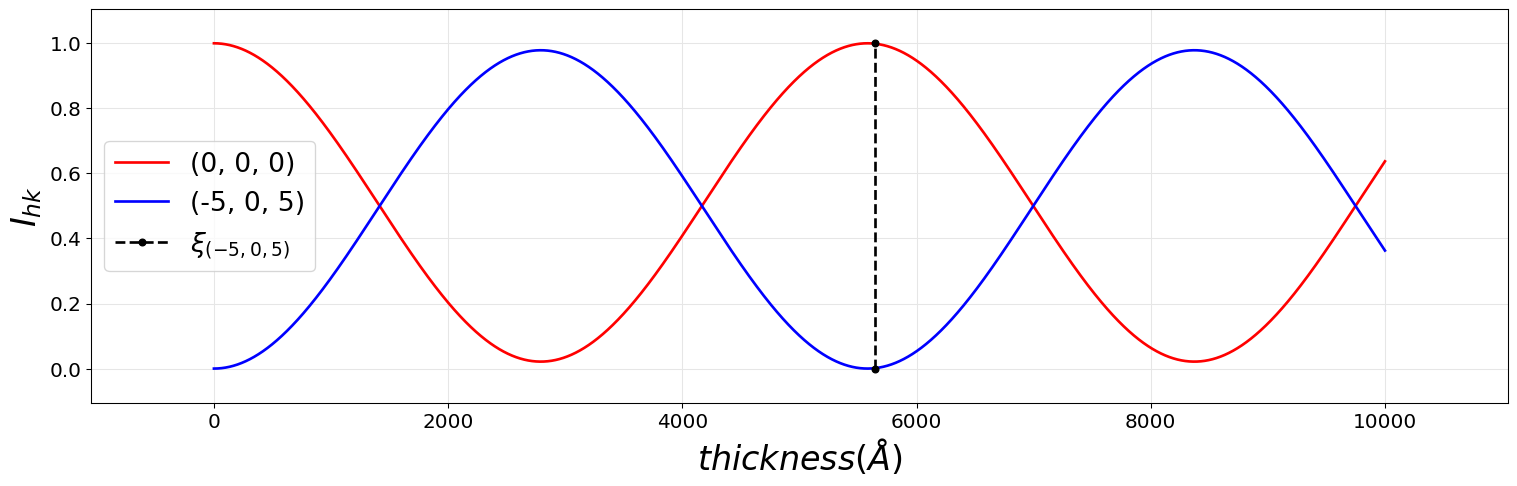

In [1256]:
b0_2x2._set_beams_vs_thickness(thicks=(0,10000,6000))
xi_g=np.real(df_Fhkl.loc[h0].xi_g)
plts = [[b0_2x2.z,I,c,h] for h,I,c in zip (b0_2x2.df_G.index,b0_2x2.Iz,['r','b']) ]
plts+= [[[xi_g]*2,[0,1],'k--o',r'$\xi_{%s}$' %h0]]
dsp.stddisp(plts,labs=['$thickness(\AA)$','$I_{hk}$'],lw=2,figsize=figs,
            );#xylims=['y',0.9,1]);

## Full sweep 
### Simulations 
By specifying the list of hkl reflections we can guarantee force these reflections into the calculations. 
This ensures that the reflections we are interested in get to be part of the simulation. The drawback of this is that some major beams with small excitation errors may not be included. 

In [1102]:
# uvw=get_uvw(osc=1,npts=200)
# Sargs['hkl']=b.df_G[['h','k','l']].values.astype(int)
# Sargs['Smax']=0.0
# rock = bl.Bloch_cont(path='dat/LTA/rocks/full',tag='',uvw=uvw,Sargs=Sargs,
#                      frames=np.arange(len(uvw)) )
rock.do('_solve_Bloch')

object saved
dat/LTA/rocks/test/u-frame__00.pkl
object saved
dat/LTA/rocks/test/u-frame__01.pkl
object saved
dat/LTA/rocks/test/u-frame__02.pkl
object saved
dat/LTA/rocks/test/u-frame__03.pkl
object saved
dat/LTA/rocks/test/u-frame__04.pkl
object saved
dat/LTA/rocks/test/u-frame__05.pkl
object saved
dat/LTA/rocks/test/u-frame__06.pkl
object saved
dat/LTA/rocks/test/u-frame__07.pkl
object saved
dat/LTA/rocks/test/u-frame__08.pkl
object saved
dat/LTA/rocks/test/u-frame__09.pkl
object saved
dat/LTA/rocks/test/u-frame__10.pkl
object saved
dat/LTA/rocks/test/u-frame__11.pkl
object saved
dat/LTA/rocks/test/u-frame__12.pkl
object saved
dat/LTA/rocks/test/u-frame__13.pkl
object saved
dat/LTA/rocks/test/u-frame__14.pkl
object saved
dat/LTA/rocks/test/u-frame__15.pkl
object saved
dat/LTA/rocks/test/u-frame__16.pkl
object saved
dat/LTA/rocks/test/u-frame__17.pkl
object saved
dat/LTA/rocks/test/u-frame__18.pkl
object saved
dat/LTA/rocks/test/u-frame__19.pkl
object saved
dat/LTA/rocks/test/u-frame_

In [1105]:
# hkls = b.df_G.sort_values('Swa')[['Sw','Vga']][1:10].index
rock = ut.load_pkl('dat/LTA/rocks/%s/rock_.pkl' %name)
rock.do('_set_beams_vs_thickness', thicks=np.arange(10,1001,10))

... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__00.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__01.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__02.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__03.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__04.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__05.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__06.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__07.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__08.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__09.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__10.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__11.pkl
... beam vs thickness ...
object saved
dat/LTA/rocks/test/u-frame__12.pkl
... beam vs thickness ...
object saved

### Rocking curves
we can see that some reflections have their whole rocking curves simulated while others are only partially covered.
Also note the narrowing of the rocking curve with thickness is not very strong. 

setting thickness to 1000A
removing Friedel pairs
total number of beams:1
gathering the intensities
gathering plots


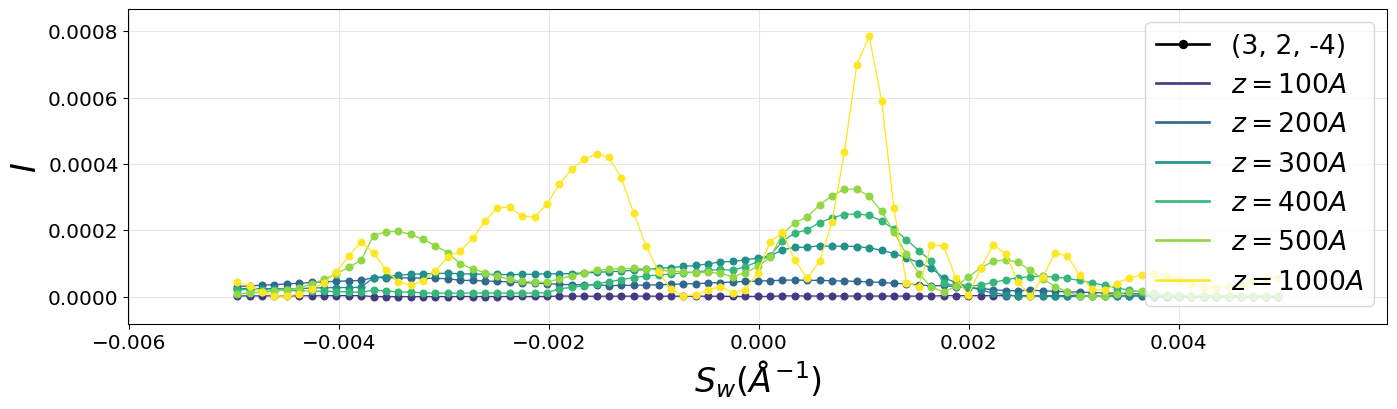

In [1106]:
# h = b.df_G.index[0]
# h = str((4,4,-6))
h=hklf[0]
# rock.do('set_thickness',verbose=False,thick=100,v=0)
# Sw,frames = rock.beams.loc[h,['Sw','Frame']]
# I = [rock.load(f).df_G.loc[h,'I'] for f in frames ]

# x='Sw'
# x='Frame'
# plts = [rock.beams.loc[h,x],I,'b-o']
# xlab = {'Frame':'frame','Sw':r'$S_w(\AA^{-1})$','theta':r'$\theta(deg)$'}[x]
# dsp.stddisp(plts,labs=[xlab,'$I$'],figsize=(12,7))
fig,ax=rock.plot_rocking(refl=[h],zs=zs,figsize=(16,4),x='Sw')#,name='figs/rock_full_%s.png' %rep(h),opt='')

In [1109]:
zs=[100,200,300,400,500]
# hklf = rock.load(0).df_G.sort_values('Swa')[['Sw','Vga']].index
rep = lambda s:s.replace(', ','_').replace('(','').replace(')','')
for h in hklf:
    fig,ax=rock.plot_rocking(refl=[h],zs=zs,figsize=figs,name='figs/rock_%s_%s.png' %(name,rep(h)),opt='sc')


removing Friedel pairs
total number of beams:1
gathering the intensities
gathering plots
Saving figure :
figs/rock_test_3_2_-4.png
removing Friedel pairs
total number of beams:1
gathering the intensities
gathering plots
Saving figure :
figs/rock_test_-5_0_5.png
removing Friedel pairs
total number of beams:1
gathering the intensities
gathering plots
Saving figure :
figs/rock_test_3_4_-5.png
removing Friedel pairs
total number of beams:1
gathering the intensities
gathering plots
Saving figure :
figs/rock_test_-2_-7_5.png
removing Friedel pairs
total number of beams:1
gathering the intensities
gathering plots
Saving figure :
figs/rock_test_4_4_-6.png
removing Friedel pairs
total number of beams:1
gathering the intensities
gathering plots
Saving figure :
figs/rock_test_7_-3_-6.png
removing Friedel pairs
total number of beams:1
gathering the intensities
gathering plots
Saving figure :
figs/rock_test_-3_-7_6.png
removing Friedel pairs
total number of beams:1
gathering the intensities
gatheri

In [1110]:
from IPython.display import display, Markdown, Latex
n=5 #number of images per rows
nrows=len(hklf)//n
hs_=np.reshape(hklf[:n*nrows],(nrows,n))

txt=''
for hs in hs_:
    txt +='\n%s\n%s --\n%s\n'%(
        ' | ' .join(hs),
        ' -- | '*(len(hs)-1),
        ' | '.join([ '![](figs/rock_%s_%s.png)' %(name,rep(h)) for h in hs] ),
    )
display(Markdown(txt))


(3, 2, -4) | (-5, 0, 5) | (3, 4, -5) | (-2, -7, 5) | (4, 4, -6)
 -- |  -- |  -- |  -- |  --
![](figs/rock_test_3_2_-4.png) | ![](figs/rock_test_-5_0_5.png) | ![](figs/rock_test_3_4_-5.png) | ![](figs/rock_test_-2_-7_5.png) | ![](figs/rock_test_4_4_-6.png)

(7, -3, -6) | (-3, -7, 6) | (-6, 0, 6) | (-5, -2, 6) | (-6, -2, 7)
 -- |  -- |  -- |  -- |  --
![](figs/rock_test_7_-3_-6.png) | ![](figs/rock_test_-3_-7_6.png) | ![](figs/rock_test_-6_0_6.png) | ![](figs/rock_test_-5_-2_6.png) | ![](figs/rock_test_-6_-2_7.png)

(4, 6, -7) | (5, 4, -7) | (8, -3, -7) | (-7, 0, 7) | (-4, -7, 7)
 -- |  -- |  -- |  -- |  --
![](figs/rock_test_4_6_-7.png) | ![](figs/rock_test_5_4_-7.png) | ![](figs/rock_test_8_-3_-7.png) | ![](figs/rock_test_-7_0_7.png) | ![](figs/rock_test_-4_-7_7.png)

(5, 6, -8) | (4, 8, -8) | (8, -1, -8) | (-5, -7, 8) | (-8, 0, 8)
 -- |  -- |  -- |  -- |  --
![](figs/rock_test_5_6_-8.png) | ![](figs/rock_test_4_8_-8.png) | ![](figs/rock_test_8_-1_-8.png) | ![](figs/rock_test_-5_-7_8.png) | ![](figs/rock_test_-8_0_8.png)


### Integration
For integration we only consider those reflections that get their whole rocking curve covered.

In [1116]:
rock._integrate_rocking(refl=rock.beams.index)

object saved
dat/LTA/rocks/test/rock_.pkl
rock.Iz updated


In [1173]:
# rock.beams
# rock.Iz_dyn.keys()
[np.max(v) for v in rock.Iz_dyn.values()]
rock.beams['Iz_max'] = 0 
rock.beams.loc[rock.Iz_dyn.keys(),'Iz_max'] = [np.max(v) for v in rock.Iz_dyn.values()]

formats = {'Iz_max':'{:>7.2e}'}     
print(rock.beams.loc[hklf].sort_values('Iz_max',ascending=False)[['Iz_max']][:6].to_string(
        formatters={k: v.format for k, v in formats.items()}))


             Iz_max
(-5, 0, 5) 1.32e-04
(-6, 0, 6) 1.10e-04
(5, 4, -7) 5.88e-05
(4, 6, -7) 2.52e-05
(-7, 0, 7) 1.63e-05
(3, 4, -5) 1.50e-05


In [1168]:
# import misc_utils ;imp.reload(misc_utils)
zs=[100,200,300,400,500,1000]
n=5
hkls=rock.beams.loc[hklf].sort_values('Iz_max',ascending=False).index
nrows=len(hkls)//n
hs_ = [hkls[np.arange(n)+i*n] for i in range(nrows)] + [hkls[n*nrows:]]
for i,hs in enumerate(hs_):
    fig,ax=misc_utils.plot_integrated(rock,refl=hs,kin=False,zs=zs,lw=2,figsize=figs,
                                     name='figs/rockInt_%s_%d.png' %(name,i),opt='sc',
                                     )#,xylims=['x',0,1005])

[5, 5, 5, 5, 2]
Saving figure :
figs/rockInt_test_0.png
Saving figure :
figs/rockInt_test_1.png
Saving figure :
figs/rockInt_test_2.png
Saving figure :
figs/rockInt_test_3.png
Saving figure :
figs/rockInt_test_4.png


In [1178]:
from IPython.display import display, Markdown, Latex
n=5 #number of images per rows
n_images = len(hs_)
nrows=n_images//n
rows = [np.arange(n)+i*n for i in range(nrows)] 
###last row
if n_images-nrows*n: rows+= [np.arange(n_images-nrows*n)]

txt=''
for r in rows :
    txt +='\n%s\n%s --\n%s\n'%(
        ' | ' .join(r.astype(str)),
        ' -- | '*(r[-1]),
        ' | '.join([ '![](figs/rockInt_%s_%d.png)' %(name,i) for i in r] ),
    )
# print(txt) 
display(Markdown(txt))


0 | 1 | 2 | 3 | 4
 -- |  -- |  -- |  -- |  --
![](figs/rockInt_test_0.png) | ![](figs/rockInt_test_1.png) | ![](figs/rockInt_test_2.png) | ![](figs/rockInt_test_3.png) | ![](figs/rockInt_test_4.png)


In [1176]:
df_Fhkl.loc[hkls[:5]].xi_g

(-5, 0, 5)    5,642.28
(-6, 0, 6)   18,039.04
(5, 4, -7)   10,389.79
(4, 6, -7)   17,934.61
(-7, 0, 7)   45,578.28
Name: xi_g, dtype: float64

## References 

- <a id="CowleyMoodie1957"></a>  Cowley, J. M., & Moodie, A. F. (1957). The scattering of electrons by atoms and crystals. I. A new theoretical approach. Acta Crystallographica, 10(10), 609–619. https://doi.org/10.1107/s0365110x57002194
- <a id="SubramanianSpence2015"></a> Subramanian, G., Basu, S., Liu, H., Zuo, J., & Spence, J. C. H. (2015). Solving protein nanocrystals by cryo-EM diffraction : Multiple scattering artifacts. Ultramicroscopy, 148, 87–93. https://doi.org/10.1016/j.ultramic.2014.08.013